* 添加高斯噪声
    * 以 0 为中心, 50 为标准差

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools
from PIL import Image, ImageEnhance, ImageOps, ImageFile

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 导入数据

In [2]:
import os

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

mkdir_if_not_exist(['./data/preprocessing'])

In [6]:
df_train = pd.read_csv('../../raw/train/Annotations/label.csv')
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
1,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
2,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
3,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn
4,Images/collar_design_labels/fc4a679c2bf209de13...,collar_design_labels,ynnnn


In [7]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

## 加载数据

In [8]:
cur_class = classes[0]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 9058


,image_id,class,label
0,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
1,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
2,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
3,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn
4,Images/collar_design_labels/fc4a679c2bf209de13...,collar_design_labels,ynnnn


In [48]:
n_ration=0.9
valid_data=df_load[int(n_ration*len(df_load)):]
df_load=df_load[:int(n_ration*len(df_load))]

In [35]:
mkdir_if_not_exist(['./data/preprocessing/Images/{}/'.format(cur_class)])

## 数据预处理

In [1]:
def randomColor(image):
    """
    对图像进行颜色抖动
    :param image: PIL的图像image
    :return: 有颜色色差的图像image
    """
    random_factor = np.random.randint(0, 31) / 10.  # 随机因子
    color_image = ImageEnhance.Color(image).enhance(random_factor)  # 调整图像的饱和度
    random_factor = np.random.randint(10, 21) / 10.  # 随机因子
    brightness_image = ImageEnhance.Brightness(color_image).enhance(random_factor)  # 调整图像的亮度
    random_factor = np.random.randint(10, 21) / 10.  # 随机因1子
    contrast_image = ImageEnhance.Contrast(brightness_image).enhance(random_factor)  # 调整图像对比度
    random_factor = np.random.randint(0, 31) / 10.  # 随机因子
    return ImageEnhance.Sharpness(contrast_image).enhance(random_factor)  # 调整图像锐度

In [8]:
rootdir = './data/train/Images/{}'.format(cur_class)  # 指明被遍历的文件夹
m = 0
outdir = './data/preprocessing/Images/{}/'.format(cur_class)

for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        currentPath = os.path.join(parent, filename)
        
        Image.open(image, mode="r")

        # 先填充, 再缩放
        img = cv2.imread(currentPath)
        dst0 = cv2.resize(img, (299, 299), interpolation=cv2.INTER_AREA)

#         # 顺逆时针旋转 20°
#         M1 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1) 
#         M2 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1) 
#         dst1 = cv2.warpAffine(dst0,M1,(cols,rows))
#         dst2 = cv2.warpAffine(dst0,M2,(cols,rows))
        
#         # 向下平移 0.2
#         M3 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
#         dst3 = cv2.warpAffine(dst0,M3,(cols,rows))
        
        # 水平翻转
        dst1 = cv2.flip(dst0, 1)
        
        # 高斯噪声
        row, column, channels = dst0.shape
        dst0.astype("float")
        Gauss_noise = np.random.normal(0, 20, (row, column, channels))
        dst2 = dst0 + Gauss_noise
        dst2 = np.where(dst2 < 0, 0, np.where(dst2 > 255, 255, dst2))
        
#         # 对翻转后图片, 左右旋转 20°
#         M4 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1)
#         M5 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1)
#         dst5 = cv2.warpAffine(dst4,M4,(cols,rows))
#         dst6 = cv2.warpAffine(dst4,M5,(cols,rows))
        
#         # 翻转后向下平移 0.2
#         M6 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
#         dst7 = cv2.warpAffine(dst4,M6,(cols,rows))
        
        cv2.imwrite(outdir + filename + "-0.jpg", dst0)
        cv2.imwrite(outdir + filename + "-1.jpg", dst1)
        cv2.imwrite(outdir + filename + "-2.jpg", dst2.astype("uint8"))
#         cv2.imwrite(outdir + filename + "-3.jpg", dst3)
#         cv2.imwrite(outdir + filename + "-4.jpg", dst4)
#         cv2.imwrite(outdir + filename + "-5.jpg", dst5)
#         cv2.imwrite(outdir + filename + "-6.jpg", dst6)
#         cv2.imwrite(outdir + filename + "-7.jpg", dst7)
        m += 1
        if m%100 == 0:
            print('{} images have preprocessed.'.format(m))

100 images have preprocessed.
200 images have preprocessed.
300 images have preprocessed.
400 images have preprocessed.
500 images have preprocessed.
600 images have preprocessed.
700 images have preprocessed.
800 images have preprocessed.
900 images have preprocessed.
1000 images have preprocessed.
1100 images have preprocessed.
1200 images have preprocessed.
1300 images have preprocessed.
1400 images have preprocessed.
1500 images have preprocessed.
1600 images have preprocessed.
1700 images have preprocessed.
1800 images have preprocessed.
1900 images have preprocessed.
2000 images have preprocessed.
2100 images have preprocessed.
2200 images have preprocessed.
2300 images have preprocessed.
2400 images have preprocessed.
2500 images have preprocessed.
2600 images have preprocessed.
2700 images have preprocessed.
2800 images have preprocessed.
2900 images have preprocessed.
3000 images have preprocessed.
3100 images have preprocessed.
3200 images have preprocessed.
3300 images have 

## 加载训练集

In [9]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

In [ ]:
X_train = np.zeros((n*3, width, width, 3), dtype=np.uint8)
y_train = np.zeros((n*3, n_class), dtype=np.uint8)

In [10]:
for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
#     if len(tmp_label) > n_class:
#         print(df_load['image_id'][i])
    for j in range(3):
        X_train[i*3+j] = cv2.resize(cv2.imread('./data/preprocessing/{0}'.format(df_load['image_id'][i] + "-%s.jpg"%j)), (width, width))
        y_train[i*3+j][tmp_label.find('y')] = 1

100%|██████████| 11299/11299 [00:47<00:00, 237.73it/s]


## 加载验证集

In [50]:
n_valid = len(valid_data)

X_valid = np.zeros((n_valid*3, width, width, 3), dtype=np.uint8)
y_valid = np.zeros((n_valid*3, n_class), dtype=np.uint8)

In [51]:
# 重置索引
valid_data = valid_data.reset_index(drop=True)

In [52]:
for i in tqdm(range(n_valid)):
    tmp_label = valid_data['label'][i]
#     if len(tmp_label) > n_class:
#         print(df_load['image_id'][i])
    for j in range(3):
        X_valid[i*3+j] = cv2.resize(cv2.imread('./data/preprocessing/{0}'.format(valid_data['image_id'][i] + "-%s.jpg"%j)), (width, width))
        y_valid[i*3+j][tmp_label.find('y')] = 1

100%|██████████| 1729/1729 [00:16<00:00, 107.74it/s]


In [14]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((33897, 299, 299, 3), (33897, 6), (3768, 299, 299, 3), (3768, 6))

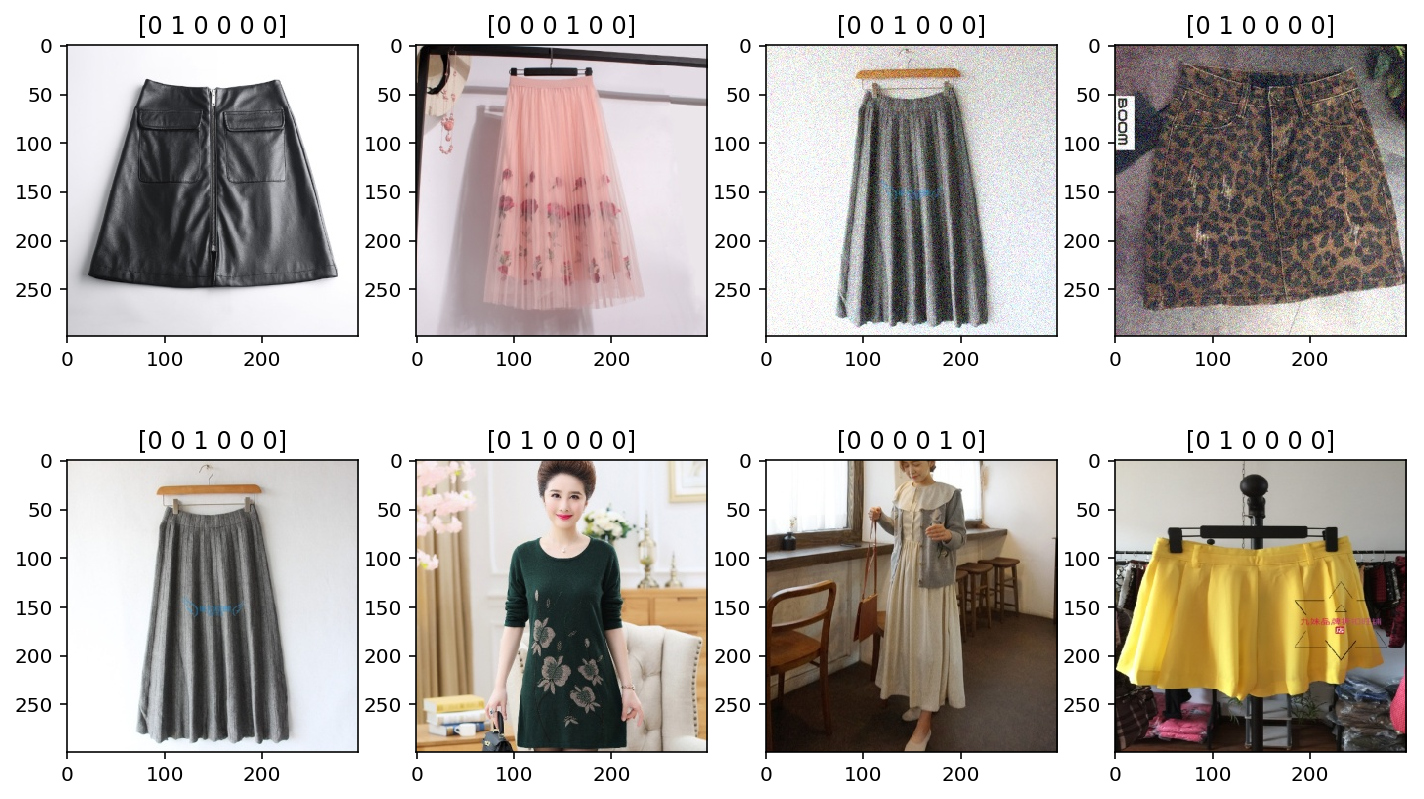

In [15]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[random_index][:,:,::-1])
    plt.title(y_train[random_index])

## 建立模型

In [53]:
del model

In [54]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

In [55]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

In [56]:
adam = Adam(lr=0.001)
prefix_cls = cur_class.split('_')[0]

In [57]:
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0511b_InceptionResNetV2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

try:
    h = model.fit(X_train, y_train, batch_size=32, epochs=1, 
                  callbacks=[EarlyStopping(patience=3), checkpointer], 
                  shuffle=True, 
                  validation_data=(X_valid, y_valid))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Train on 33897 samples, validate on 3768 samples
Epoch 1/1
33897/33897 [==============================] - 1149s 34ms/step - loss: 0.9695 - acc: 0.5993 - val_loss: 0.6159 - val_acc: 0.4177

Epoch 00001: val_loss improved from inf to 0.61594, saving model to ./models/skirt.best0511b_InceptionResNetV2.h5


In [58]:
model.load_weights('./models/{}.best0511b_InceptionResNetV2.h5'.format(prefix_cls))

In [22]:
# 学习率减小 50 倍
adam = Adam(lr=0.00002)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0511b_InceptionResNetV2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

try:
    h = model.fit(X_train, y_train, batch_size=32, epochs=1, 
                  callbacks=[EarlyStopping(patience=3), checkpointer], 
                  shuffle=True, 
                  validation_data=(X_valid, y_valid))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Train on 33897 samples, validate on 3768 samples
Epoch 1/1
33897/33897 [==============================] - 1165s 34ms/step - loss: 0.6192 - acc: 0.7448 - val_loss: 0.4841 - val_acc: 0.4676

Epoch 00001: val_loss improved from inf to 0.48408, saving model to ./models/skirt.best0511b_InceptionResNetV2.h5


In [59]:
# 测试模型
model.evaluate(X_valid, y_valid, batch_size=256)

5187/5187 [==============================] - 60s 12ms/step


[0.9742398286615007, 0.5962984380934403]

## 模型测试

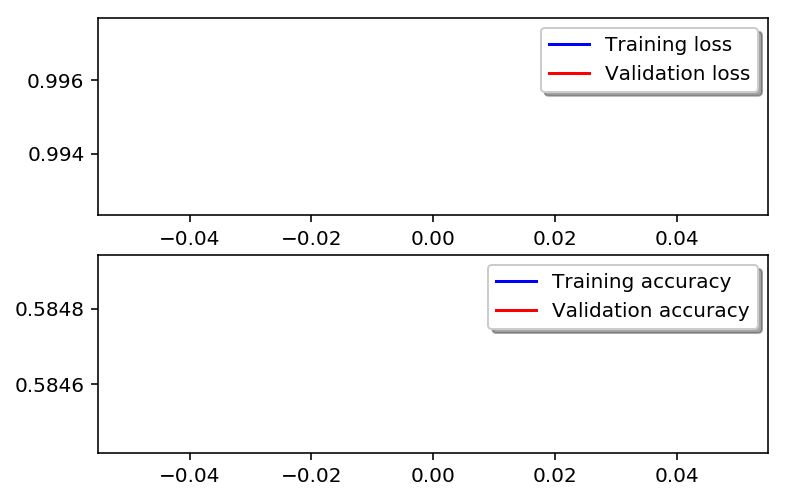

In [26]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(h.history['loss'], color='b', label="Training loss")
ax[0].plot(h.history['val_loss'], color='r', label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(h.history['acc'], color='b', label="Training accuracy")
ax[1].plot(h.history['val_acc'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 混淆矩阵

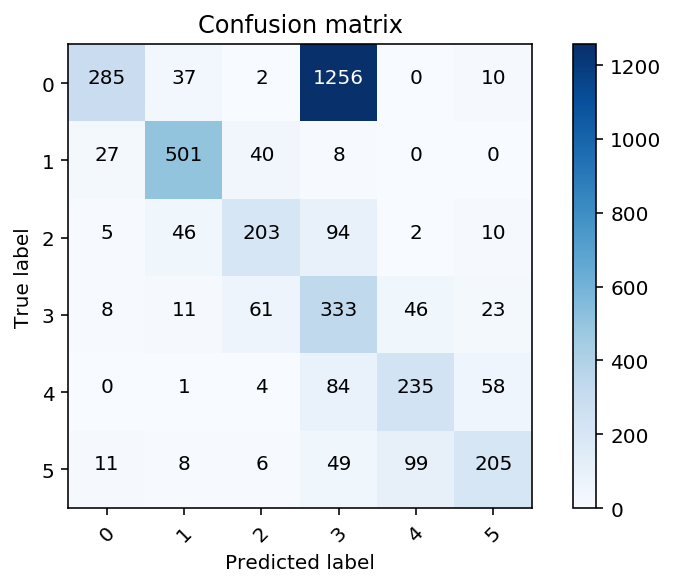

In [24]:
## Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This fuction prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plt the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(n_class))

In [ ]:
# Display some error results
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

In [ ]:
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_valid[errors]

In [ ]:
nrows = 2
ncols = 2
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """This function shows 6 images with their predicted and real labels"""
    n = 0
    
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((299, 299, 3)))
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
            n += 1

In [ ]:
#Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_imaportant_errors = sorted_dela_errors[-nrows*ncols:]

# Show the top 6 errors
display_errors(most_imaportant_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 测试集数据预处理

In [25]:
mkdir_if_not_exist(['./data/test-preprocessing/Images/{}/'.format(cur_class)])

In [26]:
rootdir = './data/week-rank/Images/{}'.format(cur_class)  # 指明被遍历的文件夹
m = 0
outdir = './data/test-preprocessing/Images/{}/'.format(cur_class)

for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        currentPath = os.path.join(parent, filename)

        # 先填充, 再缩放
        img = cv2.imread(currentPath)
        dst0 = cv2.resize(img, (299, 299), interpolation=cv2.INTER_AREA)

#         # 顺逆时针旋转 20°
#         M1 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1) 
#         M2 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1) 
#         dst1 = cv2.warpAffine(dst0,M1,(cols,rows))
#         dst2 = cv2.warpAffine(dst0,M2,(cols,rows))
        
#         # 向下平移 0.2
#         M3 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
#         dst3 = cv2.warpAffine(dst0,M3,(cols,rows))
        
        # 水平翻转
        dst1 = cv2.flip(dst0, 1)
        
        # 高斯噪声
        row, column, channels = dst0.shape
        dst0.astype("float")
        Gauss_noise = np.random.normal(3, 20, (row, column, channels))
        dst2 = dst0 + Gauss_noise
        dst2 = np.where(dst2 < 0, 0, np.where(dst2 > 255, 255, dst2))
        
#         # 对翻转后图片, 左右旋转 20°
#         M4 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1)
#         M5 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1)
#         dst5 = cv2.warpAffine(dst4,M4,(cols,rows))
#         dst6 = cv2.warpAffine(dst4,M5,(cols,rows))
        
#         # 翻转后向下平移 0.2
#         M6 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
#         dst7 = cv2.warpAffine(dst4,M6,(cols,rows))
        
        cv2.imwrite(outdir + filename + "-0.jpg", dst0)
        cv2.imwrite(outdir + filename + "-1.jpg", dst1)
        cv2.imwrite(outdir + filename + "-2.jpg", dst2.astype("uint8"))
#         cv2.imwrite(outdir + filename + "-3.jpg", dst3)
#         cv2.imwrite(outdir + filename + "-4.jpg", dst4)
#         cv2.imwrite(outdir + filename + "-5.jpg", dst5)
#         cv2.imwrite(outdir + filename + "-6.jpg", dst6)
#         cv2.imwrite(outdir + filename + "-7.jpg", dst7)
        m += 1
        if m%100 == 0:
            print('{} images have preprocessed.'.format(m))

100 images have preprocessed.
200 images have preprocessed.
300 images have preprocessed.
400 images have preprocessed.
500 images have preprocessed.
600 images have preprocessed.
700 images have preprocessed.
800 images have preprocessed.
900 images have preprocessed.
1000 images have preprocessed.
1100 images have preprocessed.
1200 images have preprocessed.
1300 images have preprocessed.
1400 images have preprocessed.
1500 images have preprocessed.
1600 images have preprocessed.
1700 images have preprocessed.
1800 images have preprocessed.
1900 images have preprocessed.
2000 images have preprocessed.
2100 images have preprocessed.


## 预处理图片进行全部预测

In [27]:
df_test = pd.read_csv('./data/week-rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [28]:
df_load2 = df_test[(df_test['class'] == cur_class)].copy()
df_load2.reset_index(inplace=True)
del df_load2['index']

print('{0}: {1}'.format(cur_class, len(df_load2)))
df_load2.head()

skirt_length_labels: 2106


,image_id,class
0,Images/skirt_length_labels/8bbcf35c0f2ef005a01...,skirt_length_labels
1,Images/skirt_length_labels/5746aaeeaf5a05ce881...,skirt_length_labels
2,Images/skirt_length_labels/55d65e83cba6307145c...,skirt_length_labels
3,Images/skirt_length_labels/7d3560bb1e2948e0283...,skirt_length_labels
4,Images/skirt_length_labels/098e249a453c37f03e1...,skirt_length_labels


In [29]:
n = len(df_load2)
width = 299 # 定义图片大小
X_test = np.zeros((n*3, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    for j in range(3):
        X_test[i*3+j] = cv2.resize(cv2.imread('./data/test-preprocessing/{0}'.format(df_load2['image_id'][i] + "-%s.jpg"%j)), (width, width))

100%|██████████| 2106/2106 [00:10<00:00, 197.73it/s]


In [30]:
# model.load_weights('./models/{}.best0511_InceptionResNetV2.h5'.format(prefix_cls))

In [31]:
test_np = model.predict(X_test, batch_size=256)

In [32]:
# 取同一张图片不同预处理方式的平均值
result = []

for i, row in df_load2.iterrows():
    tmp_list = (test_np[i*3+0] + test_np[i*3+1] + test_np[i*3+2])/3
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load2['result'] = result
df_load2.head()

,image_id,class,result
0,Images/skirt_length_labels/8bbcf35c0f2ef005a01...,skirt_length_labels,0.0004;0.0041;0.3305;0.6589;0.0039;0.0023
1,Images/skirt_length_labels/5746aaeeaf5a05ce881...,skirt_length_labels,0.0000;0.9994;0.0005;0.0002;0.0000;0.0000
2,Images/skirt_length_labels/55d65e83cba6307145c...,skirt_length_labels,0.9917;0.0001;0.0000;0.0002;0.0003;0.0077
3,Images/skirt_length_labels/7d3560bb1e2948e0283...,skirt_length_labels,0.0003;0.9414;0.0582;0.0001;0.0000;0.0000
4,Images/skirt_length_labels/098e249a453c37f03e1...,skirt_length_labels,0.0039;0.0002;0.0323;0.3472;0.3448;0.2717


In [33]:
df_load2.to_csv('./result/{}_0511a_InceptionResNetV2.csv'.format(prefix_cls), header=None, index=False)